# Deep (nonlinear) PCA-like autoencoder using MinMax scaled data
* Instead of centering data (which was a requirement for PCA) transform pixels into range [0,1]
* In theory this allows for faster convergence since weights don't need to make large steps.
* **Attention**: The regularizer loss term needs to be scaled when you change the dynamic range of the input data. Otherwise the regularizer loss is much larger than the loss for the main objective (i.e. MSE), which prevents us from training. The regularizer weight $w$ is a hyperparameter.

$\rightarrow$ MinMax scaling the input data does not seem to be very beneficial for PCADAE.

In [1]:
import keras
import keras.backend as K
import matplotlib.pyplot as plt; plt.gray()
%matplotlib inline
import numpy as np; np.random.seed(1)
import tensorflow as tf
from skimage import draw
import sys; sys.path.insert(0, "../")
import dataset

In [2]:
expl_idx = 0
vmin, vmax = 0,1
nrows, ncols = 64, 64
nsamples = 10_000
ncomponents = 3
batch_size = 32    # Small batch sizes work better for DAE.

### 1. Generate data

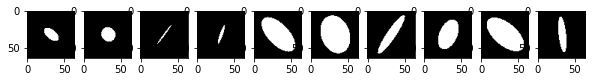

In [3]:
data = dataset.construct(nsamples, nrows, ncols, "ellipse")
X = data / 255. # min-max scale

fig, axs = plt.subplots(1, 10, figsize=(10,1))
for (i, ax) in enumerate(axs):
    ax.imshow(tf.reshape(X[i], (nrows, ncols)), vmin=0, vmax=1)

### 2. Create model

In [4]:
class CovReg(keras.regularizers.Regularizer):
    def __init__(self, w=1.0):
        self.w = w
    def __call__(self, a):
        acc  = K.sum( K.square(a[-1,:] * a[:-1,:]))
        loss = acc / (a.shape[-1]**2)
        return self.w * loss

def build_encoder(input_layer):
    return keras.Sequential([
        input_layer,
        keras.layers.Dense(units=64, activation='sigmoid', use_bias=False),
        keras.layers.Dense(units=32, activation='sigmoid', use_bias=False),
        keras.layers.Dense(units=1, activation='linear', use_bias=False),
        keras.layers.BatchNormalization(center=False, scale=False)
        ])
def build_decoder(n):
    return keras.Sequential([
        keras.layers.Input(shape=(n,)),
        keras.layers.Dense(units=32, activation='sigmoid', use_bias=False),
        keras.layers.Dense(units=64, activation='sigmoid', use_bias=False),
        keras.layers.Dense(units=nrows*ncols, activation='linear', use_bias=False)
        ])

### 3. Train model

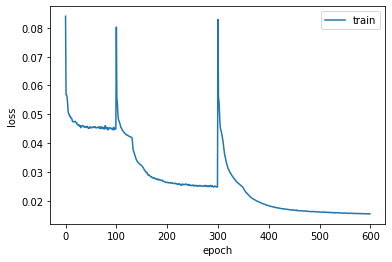

In [5]:
input_layer = keras.layers.Input(shape=(nrows*ncols,))
encoders = []

nepochs = [100, 200, 300]
for i in range(ncomponents):
    encoders.append( build_encoder(input_layer) ) # same input layer for all encoders
    decoder = build_decoder(n=i+1)  # increase input size of decoder w/ each training
    
    for e in encoders[:i]: 
        e.trainable = False # only train i-th latent neuron
    
    if i >= 1:
        encoded = keras.layers.concatenate([e(input_layer) for e in encoders], 
                                           activity_regularizer=CovReg(w=1e-7)) # adjust regularizer weight.
    else:
        encoded = encoders[0](input_layer)  # concatenate needs at least two layers.
    
    pcadae = keras.models.Model(input_layer, decoder(encoded))
    pcadae.compile(loss='mse', optimizer=keras.optimizers.Adam(1e-3)) # BN allows faster training.
    
    if i >= 1:
        pcadae.fit(X, X, epochs=nepochs[i], batch_size=batch_size, verbose=0, callbacks=[history])
    else:
        history = pcadae.fit(X, X, epochs=nepochs[i], batch_size=batch_size, verbose=0)

plt.plot(history.history['loss'], label='train')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

Z_mean = 0.5063429474830627, Z_var = 0.23043397068977356


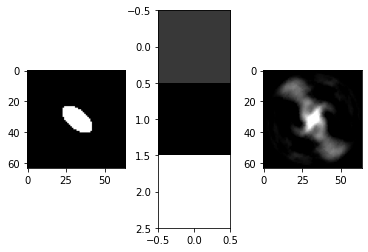

In [6]:
Z = np.array([e.predict(X) for e in encoders], dtype='float32').reshape(nsamples, ncomponents)
print(f"Z_mean = {Z.mean()}, Z_var = {Z.var()}")
X_pred = decoder(Z)

fig, ax = plt.subplots(ncols=3, nrows=1)
ax[0].imshow(tf.reshape(X[expl_idx],(nrows, ncols)), vmin=vmin, vmax=vmax)
ax[1].imshow(tf.reshape(Z[expl_idx], (-1, 1)))
ax[2].imshow(tf.reshape(X_pred[expl_idx], (nrows, ncols)), vmin=vmin, vmax=vmax)

### 5. Interpolation in latent space

In [7]:
from ipywidgets import interactive
import ipywidgets as widgets

def f(**kwargs):
    z = np.array(list(kwargs.values()), dtype='float32')
    x_pred = decoder(z.reshape(1,-1))
    plt.figure(2)
    plt.imshow(tf.reshape(x_pred,(nrows, ncols)), vmin=vmin, vmax=vmax)

scores = Z[expl_idx]
sliders = {f"PC{i+1}": widgets.FloatSlider(min=tf.reduce_min(z),max=tf.reduce_max(z),value=score) 
           for (i,score), z in zip(enumerate(scores), tf.transpose(Z))}

interactive(f, **sliders)
ix_plot = interactive(f, **sliders)
output = ix_plot.children[-1]
output.layout.height = '250px'
ix_plot

interactive(children=(FloatSlider(value=0.9437932372093201, description='PC1', max=1.8791967630386353, min=-1.…

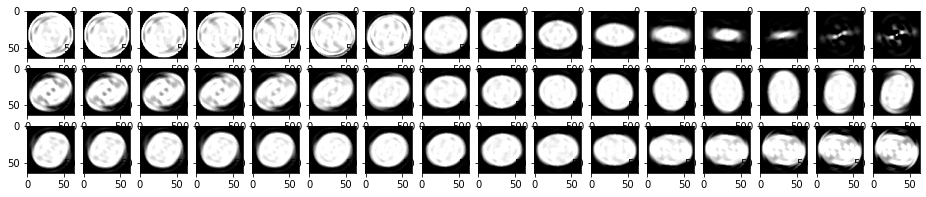

In [20]:
steps = 16
z_vars = [np.linspace(np.min(ax), np.max(ax), steps) for ax in tf.transpose(Z)] # interpolation range
fig, axs = plt.subplots(ncols=steps, nrows=ncomponents, figsize=(steps, ncomponents))

for i in range(ncomponents):
    for j in range(steps):
        z = np.zeros_like(Z[expl_idx])
        z[i] = z_vars[i][j]
        x_pred = decoder.predict(z.reshape(1, -1))
        ax = list(axs.flat)[j+i*j] if ncomponents==1 else axs[i, j]
        ax.imshow(tf.reshape(x_pred, (nrows, ncols)), vmin=vmin, vmax=vmax)

### 6. Properties of PCADAE

Dot product of all encoder weights:
 [[ 1.93317 -0.474    0.43971]
 [-0.474    1.22907  0.18616]
 [ 0.43971  0.18616  2.22581]]
===> Weights are neither orthogonal nor unit norm.
Cov of latent activations:
 tf.Tensor(
[[0.2290483  0.01130088 0.01070325]
 [0.01130088 0.23000035 0.01113756]
 [0.01070325 0.01113756 0.23229025]], shape=(3, 3), dtype=float32)


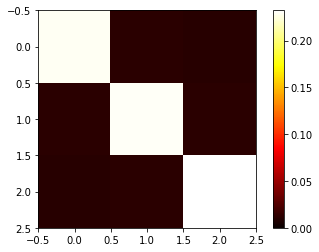

In [9]:
pcs = [e.layers[-2].weights[0] for e in encoders]
pcs = tf.concat(pcs, axis=1)
I = (tf.transpose(pcs) @ pcs)
print("Dot product of all encoder weights:\n", np.round(I, 5))
print("===> Weights are neither orthogonal nor unit norm.")

fig, ax = plt.subplots()
Z = tf.subtract(Z, tf.reduce_mean(Z, axis=0))
Z_cov = (tf.transpose(Z) @ Z) / (nsamples-1)
print("Cov of latent activations:\n", Z_cov)
plt.imshow(Z_cov, cmap='hot', vmin=0)
plt.colorbar();

### 7. Calculate MSE

In [10]:
X_pred = pcadae.predict(X)
print("MSE: ", np.square(np.subtract(X, X_pred)).mean())

MSE:  0.021961115
